Importing Libraries and Packages:

In [1]:
!pip install tensorflow
import tensorflow as tf
import struct
import os
import logging
import optuna
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape, LeakyReLU, Activation, Dropout , Conv2D ,Conv2DTranspose , BatchNormalization ,MaxPooling2D,UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from IPython import display
from sklearn.model_selection import train_test_split
import numpy as np

# Set TensorFlow logging level to suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# Set logging level to suppress TensorFlow warnings except for critical ones
tf.get_logger().setLevel(logging.ERROR) 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Loading, Preprocessing & Splitting Data

In [3]:
#Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Concatenate images and labels
all_images = np.concatenate((x_train, x_test), axis=0)
all_labels = np.concatenate((y_train, y_test), axis=0)

# scalling
all_images = all_images.reshape(all_images.shape[0], 28, 28, 1)
all_images = all_images.astype('float32')
all_images = all_images / 255.0

#Split into training,validation and test datasets in 70 , 15 and 15 %
train_X,rem_X,train_Y,rem_Y = train_test_split(all_images,all_labels,test_size=0.3,random_state=13)
val_X,test_X,val_Y,test_Y = train_test_split(rem_X,rem_Y,test_size=0.5,random_state=13)

11490434/11490434 [==============================] - 0s 0us/step


Building the Autoencoder Model :

In [4]:
class Autoencoder(Model):
    def __init__(self,latent_dim,conv_layers,kernel_size,filters,shape,dropout_rate):
        super(Autoencoder, self).__init__()

        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder_layers = []

        #First layer in decoder has the same dimension as the last layer in encoder (original size halved as many times as we applied upsampling,2 here)
        last_layer = shape[0] // (2 ** 2)

        #The flattened layer will be the inner product of the last layer in encoder that had dimensions (last_layer,last_layer,last filter size)
        flattened_dim = last_layer * last_layer * filters[conv_layers-1]

        self.decoder_layers = [Dense(flattened_dim, activation='relu'),
                               Reshape((last_layer,last_layer,filters[conv_layers-1]))]

        for layer in range(conv_layers) :

          #add the convolutional and maxpooling layer in the encoder's list
          self.encoder_layers.append(Conv2D(filters=filters[layer], kernel_size=kernel_size, activation='relu', padding='same'))
          self.encoder_layers.append(BatchNormalization())
          if(layer < conv_layers - 1) :
            #add the convolutional layer in the decoder's list with the opposite order of the filters
            self.decoder_layers.append(Conv2DTranspose(filters=filters[conv_layers-layer-1], kernel_size=kernel_size, activation='relu', padding='same'))
            self.decoder_layers.append(BatchNormalization())
            #We only apply maxpooling in the first 2 layers because otherwise we can't reconstruct the vector with the appropriate dimensions
            if(layer <=  1) :
                self.encoder_layers.append(MaxPooling2D((2, 2), padding="same"))
                self.decoder_layers.append(UpSampling2D((2, 2), interpolation='nearest'))
            self.decoder_layers.append(Dropout(dropout_rate))

          self.encoder_layers.append(Dropout(dropout_rate))

        self.encoder_layers.append(Flatten())
        self.encoder_layers.append(Dense(self.latent_dim, activation='relu'))

        #In the last layer of the decoder we apply the sigmoid function
        self.decoder_layers.append(Conv2DTranspose(filters=1, kernel_size=kernel_size, activation='sigmoid', padding='same'))

        self.encoder = tf.keras.Sequential(self.encoder_layers)
        self.decoder = tf.keras.Sequential(self.decoder_layers)

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def latent_vector(self,x) :
        return self.encoder(x)

Hyperparameter Tuning:

In [5]:
# Disable Optuna trial output
optuna.logging.set_verbosity(optuna.logging.WARNING)  

shape = (28,28,1)
predefined_filters =[[32, 64, 128],[32,64,128,256],[16,32,64,128],[16,32,64,128,256]]

def objective(trial):
    epoch = trial.suggest_categorical('epoch',[10,15,20])
    batch = trial.suggest_categorical('batch', [64,128,256])
    dim = trial.suggest_categorical('dim',[5,10,15])
    kernel = trial.suggest_categorical('kernel', [(3, 3), (5, 5), (7, 7)])
    filters = trial.suggest_categorical('filters', predefined_filters)
    rate = trial.suggest_categorical('rate', [0.5,0.6,0.7])

    autoencoder = Autoencoder(dim, len(filters), kernel, filters, shape, rate)
    autoencoder.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = autoencoder.fit(train_X, train_X,
                              epochs=epoch,
                              shuffle=True,
                              batch_size=batch,
                              callbacks=[early_stopping],
                              validation_data=(val_X, val_X))
    val_loss = history.history['val_loss'][-1]
    return val_loss

study = optuna.create_study(direction='minimize', study_name='my_study_name')
study.optimize(objective, n_trials=15)

/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3) which is of type tuple.
  warnings.warn(message)
/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (5, 5) which is of type tuple.
  warnings.warn(message)
/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (7, 7) which is of type tuple.
  warnings.warn(message)
/opt/conda/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but conta

Epoch 1/10


2024-01-02 18:47:20.086876: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder/sequential/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 43s 68ms/step - loss: 0.0750 - accuracy: 0.7875 - val_loss: 0.0648 - val_accuracy: 0.7608
Epoch 2/10
383/383 [==============================] - 24s 63ms/step - loss: 0.0596 - accuracy: 0.7912 - val_loss: 0.0549 - val_accuracy: 0.7962
Epoch 3/10
383/383 [==============================] - 24s 63ms/step - loss: 0.0529 - accuracy: 0.7933 - val_loss: 0.0435 - val_accuracy: 0.7974
Epoch 4/10
383/383 [==============================] - 24s 63ms/step - loss: 0.0430 - accuracy: 0.7973 - val_loss: 0.0335 - val_accuracy: 0.8012
Epoch 5/10
383/383 [==============================] - 24s 63ms/step - loss: 0.0351 - accuracy: 0.8014 - val_loss: 0.0285 - val_accuracy: 0.8043
Epoch 6/10
383/383 [==============================] - 24s 63ms/step - loss: 0.0311 - accuracy: 0.8036 - val_loss: 0.0239 - val_accuracy: 0.8078
Epoch 7/10
383/383 [==============================] - 24s 63ms/step - loss: 0.0290 - accuracy: 0.8047 - val_loss: 0.0223 - val_accuracy: 0.8077
Epo

2024-01-02 18:51:39.934257: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_1/sequential_2/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 18s 55ms/step - loss: 0.0851 - accuracy: 0.7792 - val_loss: 0.1040 - val_accuracy: 0.8083
Epoch 2/15
192/192 [==============================] - 9s 49ms/step - loss: 0.0629 - accuracy: 0.7897 - val_loss: 0.0846 - val_accuracy: 0.8083
Epoch 3/15
192/192 [==============================] - 9s 49ms/step - loss: 0.0496 - accuracy: 0.7938 - val_loss: 0.0491 - val_accuracy: 0.8067
Epoch 4/15
192/192 [==============================] - 9s 49ms/step - loss: 0.0424 - accuracy: 0.7969 - val_loss: 0.0380 - val_accuracy: 0.8064
Epoch 5/15
192/192 [==============================] - 9s 49ms/step - loss: 0.0389 - accuracy: 0.7988 - val_loss: 0.0337 - val_accuracy: 0.8019
Epoch 6/15
192/192 [==============================] - 9s 49ms/step - loss: 0.0381 - accuracy: 0.7993 - val_loss: 0.0321 - val_accuracy: 0.8061
Epoch 7/15
192/192 [==============================] - 9s 49ms/step - loss: 0.0360 - accuracy: 0.8005 - val_loss: 0.0297 - val_accuracy: 0.8014
Epoch 8/1

2024-01-02 18:54:10.996794: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_2/sequential_4/dropout_17/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 18s 29ms/step - loss: 0.0706 - accuracy: 0.7824 - val_loss: 0.0896 - val_accuracy: 0.8060
Epoch 2/10
383/383 [==============================] - 11s 28ms/step - loss: 0.0452 - accuracy: 0.7953 - val_loss: 0.0396 - val_accuracy: 0.8075
Epoch 3/10
383/383 [==============================] - 11s 28ms/step - loss: 0.0373 - accuracy: 0.8000 - val_loss: 0.0335 - val_accuracy: 0.8060
Epoch 4/10
383/383 [==============================] - 11s 28ms/step - loss: 0.0346 - accuracy: 0.8017 - val_loss: 0.0301 - val_accuracy: 0.8029
Epoch 5/10
383/383 [==============================] - 11s 28ms/step - loss: 0.0342 - accuracy: 0.8019 - val_loss: 0.0296 - val_accuracy: 0.8067
Epoch 6/10
383/383 [==============================] - 11s 28ms/step - loss: 0.0326 - accuracy: 0.8028 - val_loss: 0.0296 - val_accuracy: 0.8050
Epoch 7/10
383/383 [==============================] - 11s 28ms/step - loss: 0.0319 - accuracy: 0.8032 - val_loss: 0.0277 - val_accuracy: 0.8054
Epo

2024-01-02 18:56:07.740761: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_3/sequential_6/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 20s 33ms/step - loss: 0.0876 - accuracy: 0.7751 - val_loss: 0.0736 - val_accuracy: 0.8083
Epoch 2/10
383/383 [==============================] - 12s 31ms/step - loss: 0.0656 - accuracy: 0.7902 - val_loss: 0.0742 - val_accuracy: 0.8067
Epoch 3/10
383/383 [==============================] - 12s 31ms/step - loss: 0.0574 - accuracy: 0.7908 - val_loss: 0.0589 - val_accuracy: 0.8037
Epoch 4/10
383/383 [==============================] - 12s 31ms/step - loss: 0.0510 - accuracy: 0.7922 - val_loss: 0.0481 - val_accuracy: 0.7988
Epoch 5/10
383/383 [==============================] - 12s 31ms/step - loss: 0.0474 - accuracy: 0.7938 - val_loss: 0.0449 - val_accuracy: 0.8056
Epoch 6/10
383/383 [==============================] - 12s 31ms/step - loss: 0.0450 - accuracy: 0.7951 - val_loss: 0.0396 - val_accuracy: 0.8013
Epoch 7/10
383/383 [==============================] - 12s 31ms/step - loss: 0.0438 - accuracy: 0.7957 - val_loss: 0.0383 - val_accuracy: 0.8027
Epo

2024-01-02 18:58:15.408949: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_4/sequential_8/dropout_33/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 17s 47ms/step - loss: 0.0758 - accuracy: 0.7802 - val_loss: 0.0887 - val_accuracy: 0.7691
Epoch 2/20
192/192 [==============================] - 8s 44ms/step - loss: 0.0575 - accuracy: 0.7918 - val_loss: 0.0567 - val_accuracy: 0.7963
Epoch 3/20
192/192 [==============================] - 8s 44ms/step - loss: 0.0516 - accuracy: 0.7935 - val_loss: 0.0490 - val_accuracy: 0.8049
Epoch 4/20
192/192 [==============================] - 8s 44ms/step - loss: 0.0443 - accuracy: 0.7957 - val_loss: 0.0366 - val_accuracy: 0.8034
Epoch 5/20
192/192 [==============================] - 8s 44ms/step - loss: 0.0392 - accuracy: 0.7984 - val_loss: 0.0335 - val_accuracy: 0.8056
Epoch 6/20
192/192 [==============================] - 8s 44ms/step - loss: 0.0356 - accuracy: 0.8007 - val_loss: 0.0307 - val_accuracy: 0.8055
Epoch 7/20
192/192 [==============================] - 8s 44ms/step - loss: 0.0344 - accuracy: 0.8013 - val_loss: 0.0304 - val_accuracy: 0.8056
Epoch 8/2

2024-01-02 19:01:12.040245: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_5/sequential_10/dropout_40/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 13s 17ms/step - loss: 0.0833 - accuracy: 0.7806 - val_loss: 0.0809 - val_accuracy: 0.8083
Epoch 2/20
383/383 [==============================] - 6s 16ms/step - loss: 0.0661 - accuracy: 0.7913 - val_loss: 0.0571 - val_accuracy: 0.8030
Epoch 3/20
383/383 [==============================] - 6s 16ms/step - loss: 0.0535 - accuracy: 0.7921 - val_loss: 0.0445 - val_accuracy: 0.7945
Epoch 4/20
383/383 [==============================] - 6s 16ms/step - loss: 0.0481 - accuracy: 0.7945 - val_loss: 0.0403 - val_accuracy: 0.7962
Epoch 5/20
383/383 [==============================] - 6s 16ms/step - loss: 0.0441 - accuracy: 0.7963 - val_loss: 0.0369 - val_accuracy: 0.8000
Epoch 6/20
383/383 [==============================] - 6s 16ms/step - loss: 0.0414 - accuracy: 0.7976 - val_loss: 0.0358 - val_accuracy: 0.8028
Epoch 7/20
383/383 [==============================] - 6s 16ms/step - loss: 0.0416 - accuracy: 0.7974 - val_loss: 0.0351 - val_accuracy: 0.7994
Epoch 8/2

2024-01-02 19:03:37.426716: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_6/sequential_12/dropout_47/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 23s 42ms/step - loss: 0.0789 - accuracy: 0.7879 - val_loss: 0.0719 - val_accuracy: 0.8081
Epoch 2/15
383/383 [==============================] - 15s 38ms/step - loss: 0.0641 - accuracy: 0.7923 - val_loss: 0.0580 - val_accuracy: 0.8005
Epoch 3/15
383/383 [==============================] - 15s 38ms/step - loss: 0.0531 - accuracy: 0.7932 - val_loss: 0.0464 - val_accuracy: 0.8060
Epoch 4/15
383/383 [==============================] - 15s 38ms/step - loss: 0.0446 - accuracy: 0.7963 - val_loss: 0.0372 - val_accuracy: 0.8027
Epoch 5/15
383/383 [==============================] - 15s 38ms/step - loss: 0.0389 - accuracy: 0.7992 - val_loss: 0.0320 - val_accuracy: 0.8085
Epoch 6/15
383/383 [==============================] - 15s 38ms/step - loss: 0.0336 - accuracy: 0.8020 - val_loss: 0.0252 - val_accuracy: 0.8091
Epoch 7/15
383/383 [==============================] - 15s 38ms/step - loss: 0.0301 - accuracy: 0.8040 - val_loss: 0.0217 - val_accuracy: 0.8099
Epo

2024-01-02 19:07:27.105996: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_7/sequential_14/dropout_54/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


383/383 [==============================] - 24s 43ms/step - loss: 0.0777 - accuracy: 0.7851 - val_loss: 0.0863 - val_accuracy: 0.8083
Epoch 2/10
383/383 [==============================] - 16s 42ms/step - loss: 0.0657 - accuracy: 0.7913 - val_loss: 0.0628 - val_accuracy: 0.8049
Epoch 3/10
383/383 [==============================] - 16s 42ms/step - loss: 0.0591 - accuracy: 0.7915 - val_loss: 0.0527 - val_accuracy: 0.7885
Epoch 4/10
383/383 [==============================] - 16s 41ms/step - loss: 0.0588 - accuracy: 0.7904 - val_loss: 0.0501 - val_accuracy: 0.7966
Epoch 5/10
383/383 [==============================] - 16s 42ms/step - loss: 0.0533 - accuracy: 0.7915 - val_loss: 0.0470 - val_accuracy: 0.7963
Epoch 6/10
383/383 [==============================] - 16s 41ms/step - loss: 0.0508 - accuracy: 0.7921 - val_loss: 0.0460 - val_accuracy: 0.7954
Epoch 7/10
383/383 [==============================] - 16s 41ms/step - loss: 0.0493 - accuracy: 0.7923 - val_loss: 0.0439 - val_accuracy: 0.7958
Epo

2024-01-02 19:10:14.257380: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_8/sequential_16/dropout_63/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 16s 12ms/step - loss: 0.0653 - accuracy: 0.7850 - val_loss: 0.0390 - val_accuracy: 0.8067
Epoch 2/15
766/766 [==============================] - 8s 11ms/step - loss: 0.0405 - accuracy: 0.7981 - val_loss: 0.0301 - val_accuracy: 0.8059
Epoch 3/15
766/766 [==============================] - 8s 10ms/step - loss: 0.0345 - accuracy: 0.8014 - val_loss: 0.0266 - val_accuracy: 0.8080
Epoch 4/15
766/766 [==============================] - 8s 10ms/step - loss: 0.0313 - accuracy: 0.8032 - val_loss: 0.0245 - val_accuracy: 0.8098
Epoch 5/15
766/766 [==============================] - 8s 11ms/step - loss: 0.0298 - accuracy: 0.8041 - val_loss: 0.0221 - val_accuracy: 0.8102
Epoch 6/15
766/766 [==============================] - 8s 11ms/step - loss: 0.0277 - accuracy: 0.8052 - val_loss: 0.0204 - val_accuracy: 0.8101
Epoch 7/15
766/766 [==============================] - 8s 10ms/step - loss: 0.0264 - accuracy: 0.8059 - val_loss: 0.0195 - val_accuracy: 0.8105
Epoch 8/1

2024-01-02 19:12:39.151008: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_9/sequential_18/dropout_70/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 14s 12ms/step - loss: 0.0783 - accuracy: 0.7889 - val_loss: 0.0662 - val_accuracy: 0.8067
Epoch 2/15
766/766 [==============================] - 8s 11ms/step - loss: 0.0625 - accuracy: 0.7933 - val_loss: 0.0507 - val_accuracy: 0.8031
Epoch 3/15
766/766 [==============================] - 9s 11ms/step - loss: 0.0439 - accuracy: 0.7970 - val_loss: 0.0321 - val_accuracy: 0.8085
Epoch 4/15
766/766 [==============================] - 9s 11ms/step - loss: 0.0335 - accuracy: 0.8017 - val_loss: 0.0255 - val_accuracy: 0.8078
Epoch 5/15
766/766 [==============================] - 9s 11ms/step - loss: 0.0294 - accuracy: 0.8040 - val_loss: 0.0217 - val_accuracy: 0.8100
Epoch 6/15
766/766 [==============================] - 9s 11ms/step - loss: 0.0260 - accuracy: 0.8059 - val_loss: 0.0194 - val_accuracy: 0.8110
Epoch 7/15
766/766 [==============================] - 9s 11ms/step - loss: 0.0244 - accuracy: 0.8068 - val_loss: 0.0178 - val_accuracy: 0.8105
Epoch 8/1

2024-01-02 19:14:53.024964: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_10/sequential_20/dropout_75/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 13s 11ms/step - loss: 0.0726 - accuracy: 0.7869 - val_loss: 0.0552 - val_accuracy: 0.8066
Epoch 2/15
766/766 [==============================] - 8s 11ms/step - loss: 0.0486 - accuracy: 0.7955 - val_loss: 0.0338 - val_accuracy: 0.8036
Epoch 3/15
766/766 [==============================] - 8s 11ms/step - loss: 0.0357 - accuracy: 0.8007 - val_loss: 0.0270 - val_accuracy: 0.8093
Epoch 4/15
766/766 [==============================] - 8s 11ms/step - loss: 0.0298 - accuracy: 0.8038 - val_loss: 0.0223 - val_accuracy: 0.8101
Epoch 5/15
766/766 [==============================] - 8s 11ms/step - loss: 0.0270 - accuracy: 0.8053 - val_loss: 0.0197 - val_accuracy: 0.8101
Epoch 6/15
766/766 [==============================] - 9s 11ms/step - loss: 0.0250 - accuracy: 0.8064 - val_loss: 0.0372 - val_accuracy: 0.7955
Epoch 7/15
766/766 [==============================] - 9s 11ms/step - loss: 0.0240 - accuracy: 0.8070 - val_loss: 0.0174 - val_accuracy: 0.8101
Epoch 8/1

2024-01-02 19:17:05.355411: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_11/sequential_22/dropout_80/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 11s 34ms/step - loss: 0.0842 - accuracy: 0.7788 - val_loss: 0.0713 - val_accuracy: 0.8083
Epoch 2/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0674 - accuracy: 0.7908 - val_loss: 0.0645 - val_accuracy: 0.8078
Epoch 3/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0587 - accuracy: 0.7918 - val_loss: 0.0502 - val_accuracy: 0.8002
Epoch 4/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0539 - accuracy: 0.7921 - val_loss: 0.0418 - val_accuracy: 0.8021
Epoch 5/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0416 - accuracy: 0.7986 - val_loss: 0.0351 - val_accuracy: 0.8054
Epoch 6/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0360 - accuracy: 0.8013 - val_loss: 0.0319 - val_accuracy: 0.8088
Epoch 7/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0330 - accuracy: 0.8029 - val_loss: 0.0270 - val_accuracy: 0.8062
Epoch 8/2

2024-01-02 19:19:10.689888: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_12/sequential_24/dropout_85/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 11s 33ms/step - loss: 0.0806 - accuracy: 0.7867 - val_loss: 0.0985 - val_accuracy: 0.8083
Epoch 2/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0733 - accuracy: 0.7938 - val_loss: 0.0817 - val_accuracy: 0.7489
Epoch 3/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0694 - accuracy: 0.7981 - val_loss: 0.0670 - val_accuracy: 0.8021
Epoch 4/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0670 - accuracy: 0.7961 - val_loss: 0.0627 - val_accuracy: 0.7928
Epoch 5/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0674 - accuracy: 0.7935 - val_loss: 0.0620 - val_accuracy: 0.7941
Epoch 6/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0564 - accuracy: 0.7943 - val_loss: 0.0476 - val_accuracy: 0.7965
Epoch 7/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0489 - accuracy: 0.7964 - val_loss: 0.0439 - val_accuracy: 0.7964
Epoch 8/2

2024-01-02 19:21:15.555958: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_13/sequential_26/dropout_90/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


766/766 [==============================] - 13s 12ms/step - loss: 0.0529 - accuracy: 0.7917 - val_loss: 0.0300 - val_accuracy: 0.8036
Epoch 2/20
766/766 [==============================] - 8s 11ms/step - loss: 0.0303 - accuracy: 0.8043 - val_loss: 0.0214 - val_accuracy: 0.8086
Epoch 3/20
766/766 [==============================] - 8s 11ms/step - loss: 0.0237 - accuracy: 0.8076 - val_loss: 0.0179 - val_accuracy: 0.8098
Epoch 4/20
766/766 [==============================] - 8s 11ms/step - loss: 0.0211 - accuracy: 0.8088 - val_loss: 0.0163 - val_accuracy: 0.8111
Epoch 5/20
766/766 [==============================] - 8s 11ms/step - loss: 0.0194 - accuracy: 0.8096 - val_loss: 0.0151 - val_accuracy: 0.8111
Epoch 6/20
766/766 [==============================] - 8s 11ms/step - loss: 0.0185 - accuracy: 0.8101 - val_loss: 0.0145 - val_accuracy: 0.8111
Epoch 7/20
766/766 [==============================] - 8s 11ms/step - loss: 0.0179 - accuracy: 0.8103 - val_loss: 0.0138 - val_accuracy: 0.8114
Epoch 8/2

2024-01-02 19:24:11.155722: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_14/sequential_28/dropout_95/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 12s 33ms/step - loss: 0.0674 - accuracy: 0.7827 - val_loss: 0.0588 - val_accuracy: 0.8052
Epoch 2/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0373 - accuracy: 0.8008 - val_loss: 0.0419 - val_accuracy: 0.8042
Epoch 3/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0312 - accuracy: 0.8038 - val_loss: 0.0384 - val_accuracy: 0.7956
Epoch 4/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0270 - accuracy: 0.8060 - val_loss: 0.0214 - val_accuracy: 0.8103
Epoch 5/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0239 - accuracy: 0.8076 - val_loss: 0.0181 - val_accuracy: 0.8104
Epoch 6/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0220 - accuracy: 0.8085 - val_loss: 0.0249 - val_accuracy: 0.8023
Epoch 7/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0202 - accuracy: 0.8094 - val_loss: 0.0149 - val_accuracy: 0.8111
Epoch 8/2

Best Parameters for Least Loss:

In [6]:
best_params = study.best_params
best_loss = study.best_value
print("Best loss is ",best_loss,"with ",best_params)

Best loss is  0.010770115070044994 with  {'epoch': 20, 'batch': 256, 'dim': 15, 'kernel': (7, 7), 'filters': [32, 64, 128], 'rate': 0.5}


Loss & Accuracy per Epoch For Best Model :

In [7]:
layers = len(best_params['filters'])
autoencoder = Autoencoder(best_params['dim'],layers,best_params['kernel'],best_params['filters'],shape,best_params['rate'])
autoencoder.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(),metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = autoencoder.fit(train_X, train_X,
                epochs=best_params['epoch'],
                shuffle=True,
                batch_size=best_params['batch'],
                callbacks=[early_stopping],
                validation_data=(val_X, val_X))

Epoch 1/20


2024-01-02 19:26:40.481107: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inautoencoder_15/sequential_30/dropout_100/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 11s 33ms/step - loss: 0.0696 - accuracy: 0.7831 - val_loss: 0.0532 - val_accuracy: 0.8068
Epoch 2/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0424 - accuracy: 0.7984 - val_loss: 0.0387 - val_accuracy: 0.8085
Epoch 3/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0355 - accuracy: 0.8017 - val_loss: 0.0324 - val_accuracy: 0.8090
Epoch 4/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0325 - accuracy: 0.8031 - val_loss: 0.0270 - val_accuracy: 0.8071
Epoch 5/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0277 - accuracy: 0.8057 - val_loss: 0.0209 - val_accuracy: 0.8093
Epoch 6/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0245 - accuracy: 0.8072 - val_loss: 0.0188 - val_accuracy: 0.8102
Epoch 7/20
192/192 [==============================] - 6s 31ms/step - loss: 0.0223 - accuracy: 0.8083 - val_loss: 0.0173 - val_accuracy: 0.8103
Epoch 8/2

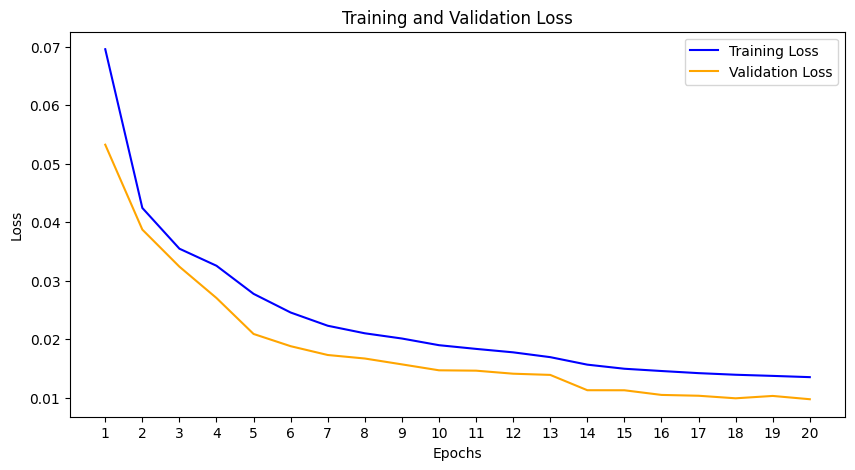

In [8]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Training Loss', color='blue')
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, len(history.history['loss']) + 1))
plt.legend()
plt.show()

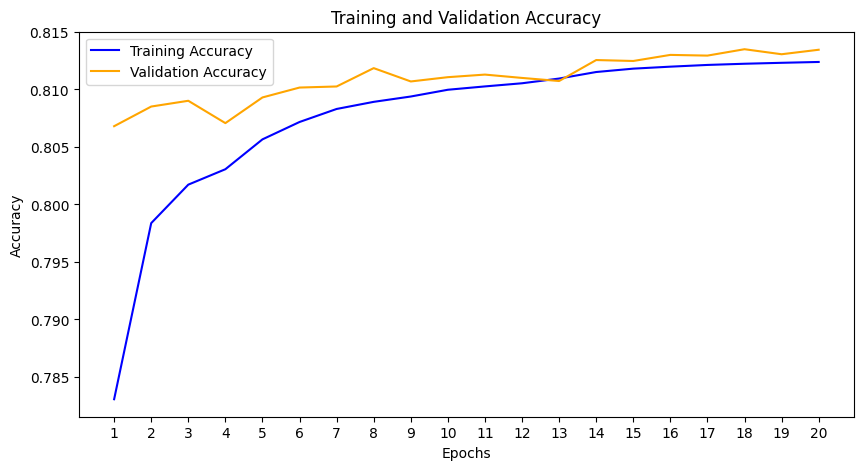

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(history.history['accuracy']) + 1))
plt.legend()
plt.show()

The plots demonstrate a small generalization gap, a trend in loss reduction.The regularization terms are only applied while training the model on the training set, inflating the training loss which explains why it ends
up being bigger.We also notice how the number of epochs is sufficient since in the last ones there is a tendency for metrics to be stabilized.

Create output datafiles in the MNIST format but using the best latent vector:

In [10]:
output_dataset_file = 'output.dat'
output_query_file = 'output_query.dat'

#Apply the best model to input file(x_train) and query file(x_test) data doing some basic preprocessing as well
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32')
x_train = x_train / 255.0

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32')
x_test = x_test / 255.0

output_imgs = autoencoder.latent_vector(x_train)
output_query_imgs = autoencoder.latent_vector(x_test)

#Restore images in the [0,255] original MNIST range turning then into unsigned char
output_imgs *= 255
output_query_imgsoutput_imgs = tf.cast(output_imgs, np.uint8) 
output_query_imgs *= 255
output_query_imgs = tf.cast(output_query_imgs, np.uint8) 

imgs = len(output_imgs)
num_rows, num_cols = 10,1

#Writing data as a binary file with big endian architecture
with open(output_dataset_file, 'wb+') as images_file:
    # Writing metadata
    images_file.write(struct.pack('>IIII', 2051, imgs, num_rows, num_cols))
    # Writing image data
    for image in output_imgs:
        images_file.write(image.numpy().tobytes())

with open(output_query_file, 'wb+') as images_file:
    # Writing image data
    for image in output_query_imgs:
        images_file.write(image.numpy().tobytes())

To avoid overfitting we implement regularization techniques such as batch normalization and dropout in every layer as well as early stopping with patience = 3.